c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


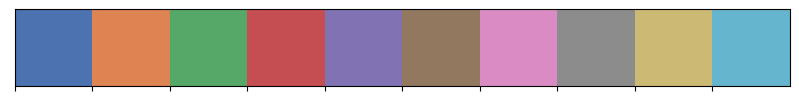

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
from sklearn.neighbors import KernelDensity
from src.model_specpred import SpectrumPredictor
from src.bayes import BayesianInference

In [3]:
pw = 0.1
nl = 2.0

with open(f"benchmarks_2023Apr05/RUN_1/bayesian_gd_pw-{pw}_nl-{nl}_Nb-40.pkl", 'rb') as f:
    data_dict = pickle.load(f)

In [4]:
error_before = []
error_after = []
for i_sample in range(100):
    error_before.append(np.linalg.norm(data_dict[i_sample]['param_mean'][12,:2] - data_dict[i_sample]['param_true'][:2]))
    error_after.append(np.linalg.norm(data_dict[i_sample]['param_mean'][14,:2] - data_dict[i_sample]['param_true'][:2]))

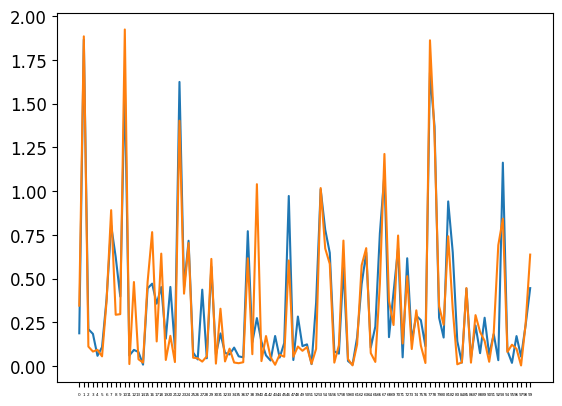

In [5]:
fig, ax = plt.subplots(1,1)
ax.plot(error_before)
ax.plot(error_after)
ax.set_xticks(np.arange(100));
ax.set_xticklabels(np.arange(100), fontsize=3);

In [6]:
i_sample = 40

In [7]:
times = data_dict[i_sample]['times']
times_finer = np.linspace(0, 3, 601)
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
test_indices = indices_dict['test']

X_test = X[test_indices]
Y_test = Y[test_indices]

model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

param_true = data_dict[i_sample]['param_true']
from src.utils_general import prepare_sample

x = X_test[i_sample]
y = Y_test[i_sample]
_, _, gamma, amp, wid = param_true
amp_factor = (amp / y[2:].max()).item()
_, func_I_conv, func_I_noconv = prepare_sample(
    x, y, gamma, times_finer, pulse_width=pw, normalize_to_value=100, 
    elas_amp_factor=amp_factor, elas_wid=wid, elas_amp_abs_max=10.)
signals = func_I_conv(times)
signals_finer = func_I_conv(times_finer)

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):


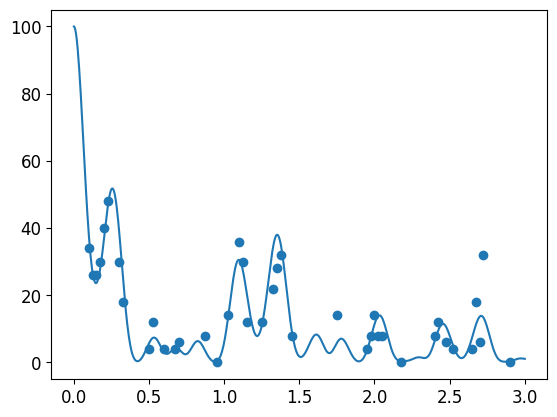

In [8]:
signals_finer = func_I_conv(times_finer)

plt.plot(times_finer, signals_finer)
plt.scatter(data_dict[i_sample]['measurement_settings'], data_dict[i_sample]['measurements'])

In [9]:
J_grid, D_grid = np.meshgrid(np.linspace(-3,-1,201),np.linspace(-1,0,101))
X_grid = np.concatenate([J_grid[...,None], D_grid[...,None]], axis=-1).reshape(-1,2)

n_iter_before = 6
X_before = data_dict[i_sample]['particles'][n_iter_before,:2]
X_weight_before = data_dict[i_sample]['particle_weights'][n_iter_before]
X_true = data_dict[i_sample]['param_true']

kde_before = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=X_weight_before)
log_dens_before = kde_before.score_samples(X_grid).reshape(J_grid.shape)

likyhd = data_dict[i_sample]['likyhd'][n_iter_before]
kde_likyhd = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, sample_weight=likyhd)

log_dens_likyhd = kde_likyhd.score_samples(X_grid).reshape(J_grid.shape)

n_iter_after = 7
X_after = data_dict[i_sample]['particles'][n_iter_after,:2]
X_weight_after = data_dict[i_sample]['particle_weights'][n_iter_after]
kde_after = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_after.T, sample_weight=X_weight_after)
# log_dens = kde.score_samples(X_plot)

log_dens_after = kde_after.score_samples(X_grid).reshape(J_grid.shape)

# log_dens_likyhd


In [10]:
data_dict[i_sample]['particles'].shape

(41, 5, 501)

In [11]:
data_dict[i_sample]['param_mean'].shape

(41, 5)

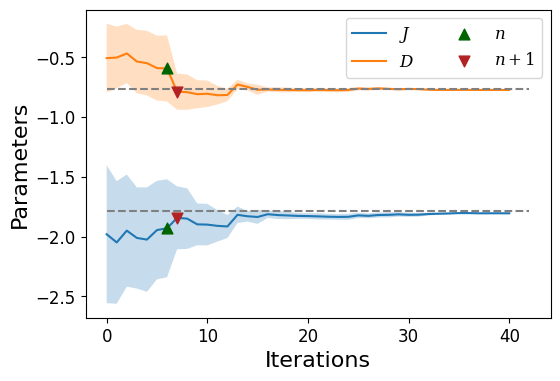

In [54]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(data_dict[i_sample]['param_mean'][:,0], label='$J$')
ax.plot(data_dict[i_sample]['param_mean'][:,1], label='$D$')
ax.fill_between(np.arange(41), data_dict[i_sample]['param_mean'][:,0] - data_dict[i_sample]['param_std'][:,0],
    data_dict[i_sample]['param_mean'][:,0] + data_dict[i_sample]['param_std'][:,0], alpha=0.25)
ax.fill_between(np.arange(41), data_dict[i_sample]['param_mean'][:,1] - data_dict[i_sample]['param_std'][:,1],
    data_dict[i_sample]['param_mean'][:,1] + data_dict[i_sample]['param_std'][:,1], alpha=0.25)
ax.scatter([n_iter_before, n_iter_before], [data_dict[i_sample]['param_mean'][n_iter_before,0], data_dict[i_sample]['param_mean'][n_iter_before,1]], 
           marker='^', s=50, zorder=3, color='forestgreen', label='$n$')
ax.scatter([n_iter_after, n_iter_after], [data_dict[i_sample]['param_mean'][n_iter_after,0], data_dict[i_sample]['param_mean'][n_iter_after,1]], 
           marker='v', s=50, zorder=3, color='firebrick', label='$n+1$')
ax.hlines(data_dict[i_sample]['param_true'][0], 0, 42, linestyles='--', colors='gray')
ax.hlines(data_dict[i_sample]['param_true'][1], 0, 42, linestyles='--', colors='gray')
ax.legend(ncols=2)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Parameters', fontsize=14)
fig.savefig('figures/bayesian_illustration/parameters.pdf', bbox_inches='tight')

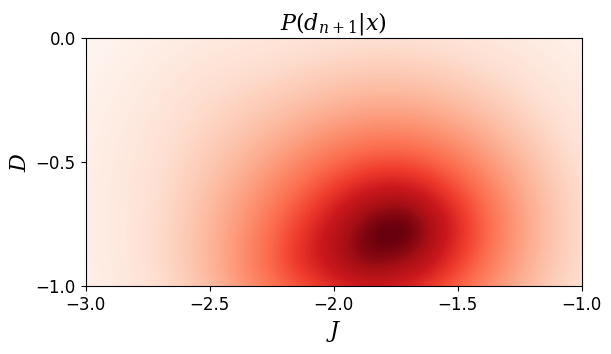

In [65]:
import matplotlib.ticker as plticker

xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals


fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_likyhd), extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
# ax.scatter(X[0], X[1])
# ax.scatter(X_true[0], X_true[1], marker='*', color='firebrick')
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P(d_{n+1}|x)$', fontsize=14)
fig.savefig('figures/bayesian_illustration/likyhd.pdf', bbox_inches='tight')

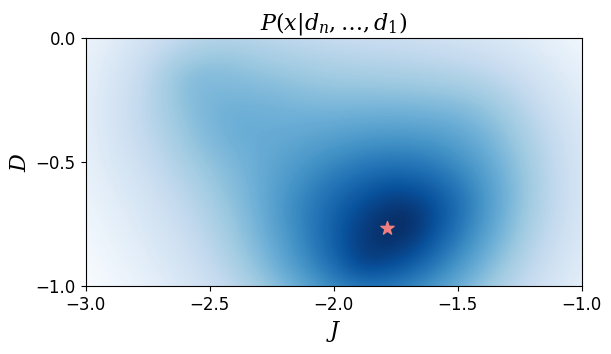

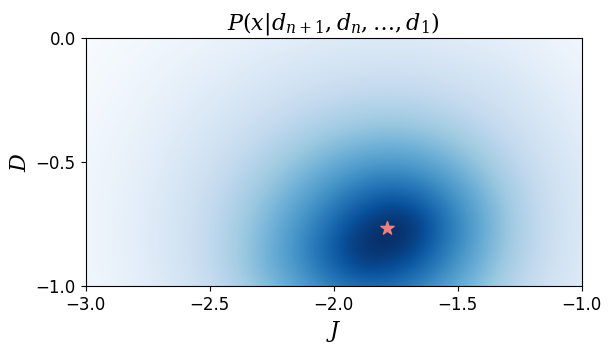

In [66]:

fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P(x|d_{n}, \ldots, d_{1})$', fontsize=14)
fig.savefig('figures/bayesian_illustration/prior.pdf', bbox_inches='tight')

fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.contour(J_grid, D_grid, np.exp(log_dens_likyhd), levels=5, origin='lower', colors='gray')
# ax.scatter(X[0], X[1])
ax.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax.set_aspect('equal')
ax.set_xlabel('$J$', fontsize=14)
ax.xaxis.set_major_locator(xloc)
ax.set_ylabel('$D$', fontsize=14)
ax.yaxis.set_major_locator(yloc)
ax.set_title(r'$P(x|d_{n+1}, d_{n}, \ldots, d_{1})$', fontsize=14)
fig.savefig('figures/bayesian_illustration/posterior.pdf', bbox_inches='tight')

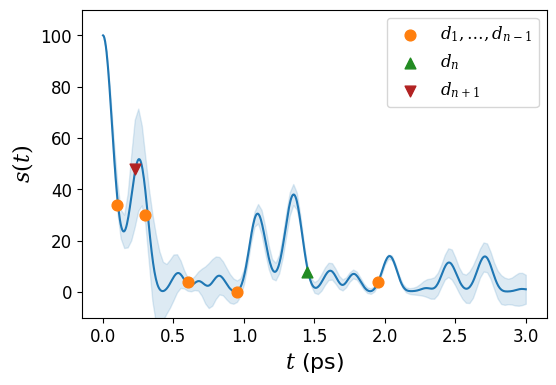

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(times_finer, signals_finer, zorder=0, color='C0')
ax.scatter(data_dict[i_sample]['measurement_settings'][:n_iter_before-1], 
           data_dict[i_sample]['measurements'][:n_iter_before-1], 
           zorder=2, color='C1', s=50, label='$d_{1}, \ldots, d_{n-1}$')
ax.fill_between(times, signals-data_dict[i_sample]['utility'][n_iter_before], signals+data_dict[i_sample]['utility'][n_iter_before], 
                alpha=0.15, zorder=1, color='C0')
ax.scatter(data_dict[i_sample]['measurement_settings'][n_iter_before-1], data_dict[i_sample]['measurements'][n_iter_before-1], 
           marker='^', zorder=2, color='forestgreen', s=50, label='$d_{n}$')
ax.scatter(data_dict[i_sample]['measurement_settings'][n_iter_before], data_dict[i_sample]['measurements'][n_iter_before], 
           marker='v', zorder=3, color='firebrick', s=50, label='$d_{n+1}$')
# ax.vlines(times[np.argmax(data_dict[i_sample]['utility'][n_iter_before])], -100, 100, linestyles='--', color='gray')
ax.set_ylim([-10, 110])
ax.legend()
ax.set_xlabel('$t$ (ps)', fontsize=14)
ax.set_ylabel('$s(t)$', fontsize=14)
fig.savefig('figures/bayesian_illustration/st.pdf', bbox_inches='tight')

C:\Users\zhant\AppData\Local\Temp\ipykernel_5880\1623582431.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


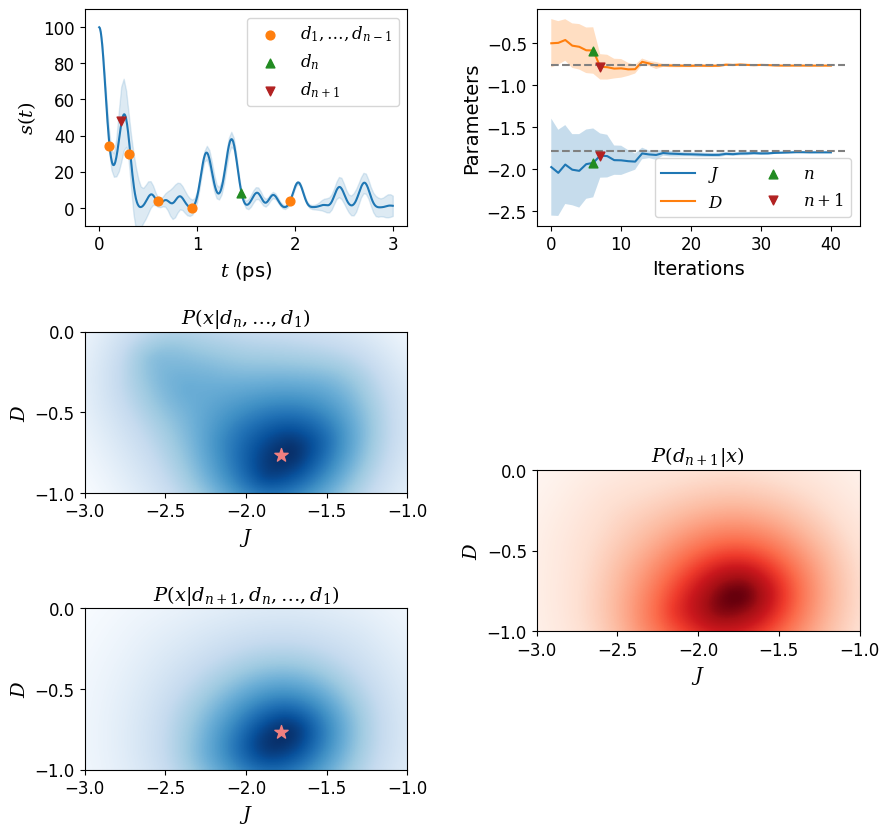

In [109]:
import matplotlib.ticker as plticker

xloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
yloc = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=3, ncols=2, wspace=0.4, hspace=0.5, height_ratios=[1.2,1,1])

ax_st = fig.add_subplot(gs[0,0])
ax_st.plot(times_finer, signals_finer, zorder=0, color='C0')
ax_st.scatter(data_dict[i_sample]['measurement_settings'][:n_iter_before-1], 
           data_dict[i_sample]['measurements'][:n_iter_before-1], 
           zorder=2, color='C1', s=40, label='$d_{1}, \ldots, d_{n-1}$')
ax_st.fill_between(times, signals-data_dict[i_sample]['utility'][n_iter_before], signals+data_dict[i_sample]['utility'][n_iter_before], 
                alpha=0.15, zorder=1, color='C0')
ax_st.scatter(data_dict[i_sample]['measurement_settings'][n_iter_before-1], data_dict[i_sample]['measurements'][n_iter_before-1], 
           marker='^', zorder=2, color='forestgreen', s=40, label='$d_{n}$')
ax_st.scatter(data_dict[i_sample]['measurement_settings'][n_iter_before], data_dict[i_sample]['measurements'][n_iter_before], 
           marker='v', zorder=3, color='firebrick', s=40, label='$d_{n+1}$')
# ax.vlines(times[np.argmax(data_dict[i_sample]['utility'][n_iter_before])], -100, 100, linestyles='--', color='gray')
ax_st.set_ylim([-10, 110])
ax_st.legend(fontsize=12)
ax_st.set_xlabel('$t$ (ps)', fontsize=14)
ax_st.set_ylabel('$s(t)$', fontsize=14)


ax_pm = fig.add_subplot(gs[0,1])
ax_pm.plot(data_dict[i_sample]['param_mean'][:,0], label='$J$')
ax_pm.plot(data_dict[i_sample]['param_mean'][:,1], label='$D$')
ax_pm.fill_between(np.arange(41), data_dict[i_sample]['param_mean'][:,0] - data_dict[i_sample]['param_std'][:,0],
    data_dict[i_sample]['param_mean'][:,0] + data_dict[i_sample]['param_std'][:,0], alpha=0.25)
ax_pm.fill_between(np.arange(41), data_dict[i_sample]['param_mean'][:,1] - data_dict[i_sample]['param_std'][:,1],
    data_dict[i_sample]['param_mean'][:,1] + data_dict[i_sample]['param_std'][:,1], alpha=0.25)
ax_pm.scatter([n_iter_before, n_iter_before], [data_dict[i_sample]['param_mean'][n_iter_before,0], data_dict[i_sample]['param_mean'][n_iter_before,1]], 
           marker='^', s=40, zorder=3, color='forestgreen', label='$n$')
ax_pm.scatter([n_iter_after, n_iter_after], [data_dict[i_sample]['param_mean'][n_iter_after,0], data_dict[i_sample]['param_mean'][n_iter_after,1]], 
           marker='v', s=40, zorder=3, color='firebrick', label='$n+1$')
ax_pm.hlines(data_dict[i_sample]['param_true'][0], 0, 42, linestyles='--', colors='gray')
ax_pm.hlines(data_dict[i_sample]['param_true'][1], 0, 42, linestyles='--', colors='gray')
ax_pm.legend(ncols=2, fontsize=12)
ax_pm.set_xlabel('Iterations', fontsize=14)
ax_pm.set_ylabel('Parameters', fontsize=14)

ax_prior = fig.add_subplot(gs[1,0])
ax_prior.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax_prior.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax_prior.set_aspect('equal')
ax_prior.set_xlabel('$J$', fontsize=14)
ax_prior.xaxis.set_major_locator(xloc)
ax_prior.set_ylabel('$D$', fontsize=14)
ax_prior.yaxis.set_major_locator(yloc)
ax_prior.set_title(r'$P(x|d_{n}, \ldots, d_{1})$', fontsize=14)

ax_post = fig.add_subplot(gs[2,0])
ax_post.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.contour(J_grid, D_grid, np.exp(log_dens_likyhd), levels=5, origin='lower', colors='gray')
# ax.scatter(X[0], X[1])
ax_post.scatter(X_true[0], X_true[1], marker='*', color='lightcoral', s=100)
ax_post.set_aspect('equal')
ax_post.set_xlabel('$J$', fontsize=14)
ax_post.xaxis.set_major_locator(xloc)
ax_post.set_ylabel('$D$', fontsize=14)
ax_post.yaxis.set_major_locator(yloc)
ax_post.set_title(r'$P(x|d_{n+1}, d_{n}, \ldots, d_{1})$', fontsize=14)

ax_likyhd = fig.add_subplot(gs[1:,1])
ax_likyhd.imshow(np.exp(log_dens_likyhd), extent=[-3, -1, -1, 0], origin='lower', cmap='Reds')
# ax.scatter(X[0], X[1])
# ax.scatter(X_true[0], X_true[1], marker='*', color='firebrick')
ax_likyhd.set_aspect('equal')
ax_likyhd.set_xlabel('$J$', fontsize=14)
ax_likyhd.xaxis.set_major_locator(xloc)
ax_likyhd.set_ylabel('$D$', fontsize=14)
ax_likyhd.yaxis.set_major_locator(yloc)
ax_likyhd.set_title(r'$P(d_{n+1}|x)$', fontsize=14)

fig.tight_layout()
fig.savefig('figures/bayesian_illustration/bayesian_illustration.pdf', bbox_inches='tight')